# CRISP-DM Process

## 1. Business Questions
- Which of the 2 cities has the highest prices in the same season?
- What is the season when the largest number of rooms are available in both cities?
- What is the most rented type of room in both cities?
- Which city has the most positive reviews by type of room in both cities?

## 2. Prepare data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
b_cal = pd.read_csv('../data/boston/calendar.csv')
s_cal = pd.read_csv('../data/seattle/calendar.csv')
b_list = pd.read_csv('../data/boston/listings.csv')
s_list = pd.read_csv('../data/seattle/listings.csv')
b_rev = pd.read_csv('../data/boston/reviews.csv')
s_rev = pd.read_csv('../data/seattle/reviews.csv')

### 2.1. Which of the 2 cities has the highest prices in the same season?

*Boston*

In [3]:
b_cal['price'] = b_cal['price'].str.replace('$','').str.replace(',','').astype(float)
print(b_cal.shape)

b_cal_t = b_cal[b_cal['available']=='t']
b_cal_t['period'] = b_cal_t['date'].astype(str).str.replace('-','').str[:6]#.astype(int)
b_cal_t = b_cal_t.merge(b_list[['id','room_type']],left_on = 'listing_id',right_on = 'id', how = 'left')
b_cal_t = b_cal_t.groupby(['period','room_type']).agg(price_mean = ('price','mean')).reset_index()
b_cal_t.head()

(1308890, 4)


,period,room_type,price_mean
0,201609,Entire home/apt,339.968199
1,201609,Private room,104.516574
2,201609,Shared room,116.165652
3,201610,Entire home/apt,327.463279
4,201610,Private room,98.504221


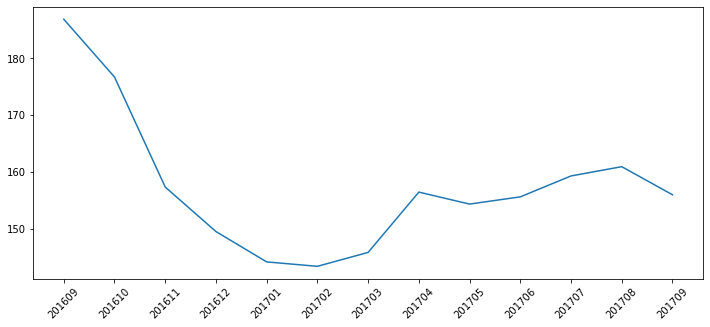

In [4]:
aux_b = b_cal_t.groupby('period').agg({'price_mean':'mean'}).reset_index()
plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
plt.plot(aux_b.period, aux_b.price_mean)
plt.savefig('../images/boston_price_period.png')

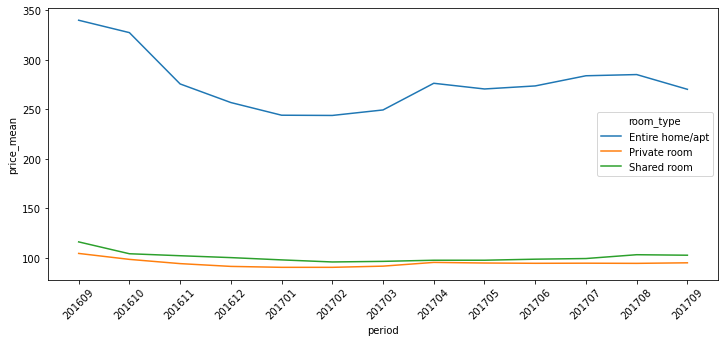

In [5]:
plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
sns.lineplot(data=b_cal_t, x="period", y="price_mean", hue="room_type")
plt.savefig('../images/boston_price_period_roomtype.png')

*Seattle*

In [6]:
s_cal['price'] = s_cal['price'].str.replace('$','').str.replace(',','').astype(float)
print(s_cal.shape)

s_cal_t = s_cal[s_cal['available']=='t']
s_cal_t['period'] = s_cal_t['date'].astype(str).str.replace('-','').str[:6]#.astype(int)
s_cal_t = s_cal_t.merge(s_list[['id','room_type']],left_on = 'listing_id',right_on = 'id', how = 'left')
s_cal_t = s_cal_t.groupby(['period','room_type']).agg(price_mean = ('price','mean')).reset_index()
s_cal_t.head()

(1393570, 4)


,period,room_type,price_mean
0,201601,Entire home/apt,151.504410
1,201601,Private room,76.706399
2,201601,Shared room,49.059829
3,201602,Entire home/apt,155.449346
4,201602,Private room,76.177341


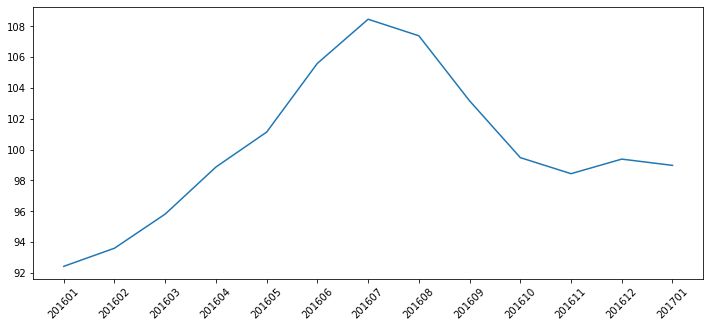

In [7]:
aux_s = s_cal_t.groupby('period').agg({'price_mean':'mean'}).reset_index()
plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
plt.plot(aux_s.period, aux_s.price_mean)
plt.savefig('../images/seattle_price_period.png')

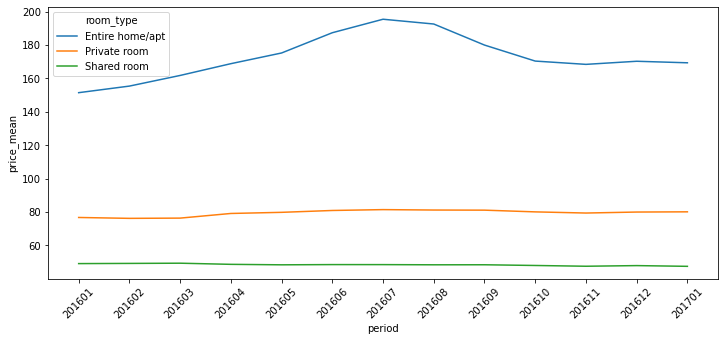

In [8]:
plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
sns.lineplot(data=s_cal_t, x="period", y="price_mean", hue="room_type")
plt.savefig('../images/seattle_price_period_roomtype.png')

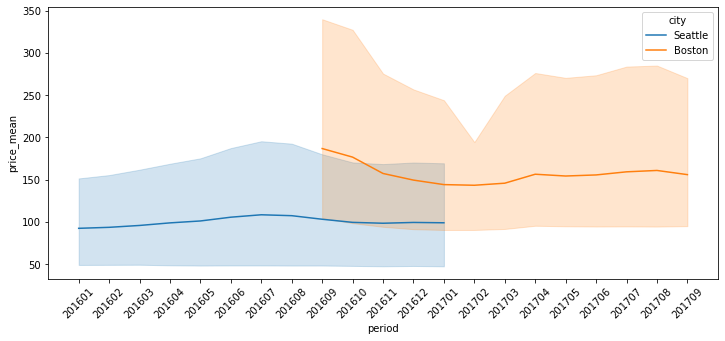

In [9]:
b_t = b_cal_t.copy()
b_t['city'] = 'Boston'
s_t = s_cal_t.copy()
s_t['city'] = 'Seattle'
aux = pd.concat([b_t, s_t], ignore_index = True).sort_values(by = ['period','room_type','city'], ascending = [True, True, True])

plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
sns.lineplot(data=aux, x="period", y="price_mean", hue='city')
plt.savefig('../images/price_period_bothcities.png')

#### Conclusions:
- In the city of Boston and Seattle, the entire home/apartment is the most expensive. In Boston, the price is around 250 to 350 dollars approximately. On the other hand, in Seattle it is around 140 to 200 dollars.
- In Boston, a shared room is only slightly more expensive than a private room, while in Seattle, a private room is clearly more expensive than a shared room.
- In the same months, the median rental price is clearly higher in Boston than in Seattle

### 2.2. What is the season when the largest number of rooms are available in both cities?

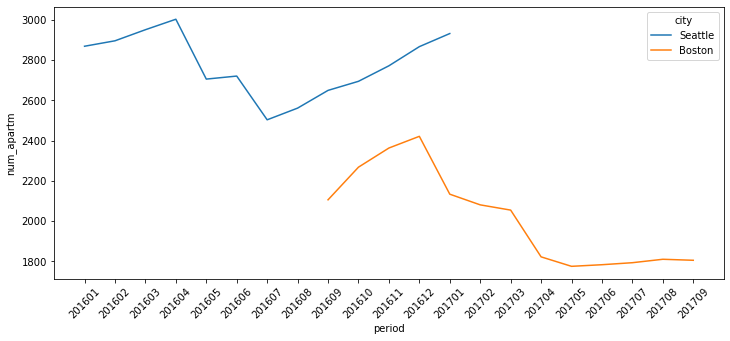

In [10]:
b_cal_t = b_cal[b_cal['available']=='t']
b_cal_t['period'] = b_cal_t['date'].astype(str).str.replace('-','').str[:6]
b_cal_t = b_cal_t.groupby('period').agg(num_apartm = ('listing_id','nunique')).reset_index()
b_cal_t['city'] = 'Boston'

s_cal_t = s_cal[s_cal['available']=='t']
s_cal_t['period'] = s_cal_t['date'].astype(str).str.replace('-','').str[:6]
s_cal_t = s_cal_t.groupby('period').agg(num_apartm = ('listing_id','nunique')).reset_index()
s_cal_t['city'] = 'Seattle'

aux = pd.concat([b_cal_t, s_cal_t], ignore_index = True).sort_values(by = ['period','city'], ascending = True)

plt.figure(figsize = (12,5))
plt.tick_params(axis='x', rotation=45)
sns.lineplot(data=aux, x="period", y="num_apartm", hue='city')
plt.savefig('../images/available_period_bothcities.png')

#### Conclusion:
- In the city of Seattle, the month with the most rental availability is in the month of March. Contrary to Boston that there are a greater number of sites available in December. It should be noted that in Seattle there are always more places available than in Boston

### 2.3. What is the most rented type of room in both cities?

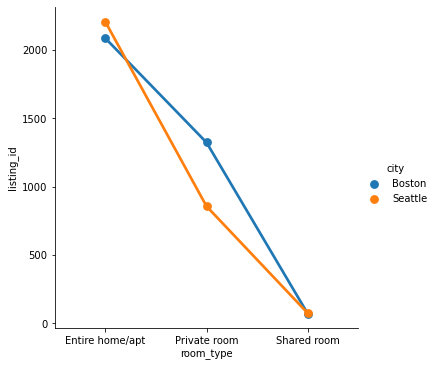

In [11]:
# number of distinct places not available by room type in Boston
b_cal_room = b_cal.merge(b_list[['id','room_type']],left_on = 'listing_id',right_on = 'id', how = 'left')
del b_cal_room['id']

# number of distinct places not available by room type in Seattle
s_cal_room = s_cal.merge(s_list[['id','room_type']],left_on = 'listing_id',right_on = 'id', how = 'left')
del s_cal_room['id']

b1 = b_cal_room[b_cal_room['available']=='f'].groupby('room_type').agg({'listing_id':'nunique'}).reset_index()
b1['city'] = 'Boston'

s1 = s_cal_room[s_cal_room['available']=='f'].groupby('room_type').agg({'listing_id':'nunique'}).reset_index()
s1['city'] = 'Seattle'

bs = pd.concat([b1, s1], ignore_index = True)
sns.factorplot(data = bs, x = 'room_type', y = 'listing_id', hue = 'city')
plt.savefig('../images/notavailable_roomtype_bothcities.png')

In [12]:
# number of distinct places available by room type in Boston
b_cal_room[b_cal_room['available']=='t'].groupby('room_type').agg({'listing_id':'nunique',
                                                                   'price':['mean','median','min','max']})

listing_id       price                     
                   nunique        mean median   min     max
room_type                                                  
Entire home/apt       1760  272.836833  230.0  11.0  4000.0
Private room          1081   93.963964   80.0  20.0  7163.0
Shared room             65  100.288346   74.0  20.0   500.0

In [13]:
# number of distinct places available by room type in Seattle
s_cal_room[s_cal_room['available']=='t'].groupby('room_type').agg({'listing_id':'nunique',
                                                                   'price':['mean','median','min','max']})

listing_id       price                     
                   nunique        mean median   min     max
room_type                                                  
Entire home/apt       2463  173.469068  139.0  10.0  1650.0
Private room          1143   79.354499   70.0  20.0   420.0
Shared room            117   48.429291   40.0  20.0   120.0

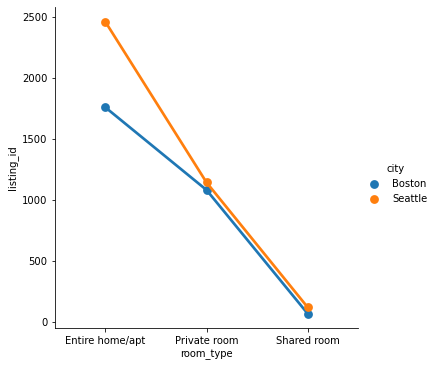

In [14]:
b1 = b_cal_room[b_cal_room['available']=='t'].groupby('room_type').agg({'listing_id':'nunique'}).reset_index()
b1['city'] = 'Boston'

s1 = s_cal_room[s_cal_room['available']=='t'].groupby('room_type').agg({'listing_id':'nunique'}).reset_index()
s1['city'] = 'Seattle'

bs = pd.concat([b1, s1], ignore_index = True)
sns.factorplot(data = bs, x = 'room_type', y = 'listing_id', hue = 'city')
plt.savefig('../images/available_roomtype_bothcities.png')

#### Conclusions:
- Private rooms are more popular in Boston, while entire houses/apartments are slightly more popular in Seattle.
- Entire houses/apartments are more availables in Seattle.
- In both cities the entire home/apt is the most rented. However, the same trend continues in the offers available
- In all types of rooms, Boston has the most expensive prices, only in the case of private rooms are the prices more similar.

### 2.4. Which city has the most positive reviews by type of room in both cities?

*Sentiment Model*

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time
import joblib

In [17]:
# In this case, i will train a sentiment classifier based on tripdavisor hotel reviews. The url: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews
# Then i will use the model to predict the sentiment in our data
df_sentiment = pd.read_csv('../data/trip_advisor_sentiment/tripadvisor_hotel_reviews.csv')
print(df_sentiment.shape)
df_sentiment.columns = [x.lower() for x in df_sentiment.columns]
df_sentiment.head()

(20491, 2)


,review,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [18]:
# The data doesn't specify the sentiment. For that reason I will assign manually the labels
df_sentiment['sentiment'] = df_sentiment['rating'].map({1:'negative',2:'negative',
                                                        3:'neutral',4:'neutral',
                                                        5:'positive'})
df_sentiment.sentiment.value_counts(1)

positive    0.441853
neutral     0.401298
negative    0.156849
Name: sentiment, dtype: float64

In [19]:
# Cleaning and vectorizing reviews
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
vectorizer = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = vectorizer.fit_transform(df_sentiment['review'])
joblib.dump(vectorizer, '../objects/vectorizer.pkl')

['../objects/vectorizer.pkl']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(text_counts, df_sentiment['sentiment'], test_size = 0.4, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [21]:
def print_results(results):
    """
    Print accuracy for each combination of model parameters and the best parameters
    
    Arguments:
        results: trained model
    
    Returns:
        The accuracy for each combination of model parameters and the best parameters    
    """
    
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
def evaluate_model(name, model, features, labels):
    """
    Evaluate clasification model and print the principal metrics and time of execution
    
    Arguments:
        name: trained model name
        model: trained model
        features: data to evaluate
        labels: true class
    
    Returns:
        The accuracy/precision/recall/latency for the model  
    """
    
    
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred, average = 'macro'), 3)
    recall = round(recall_score(labels, pred, average = 'macro'), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))   

In [23]:
%%time

nb = MultinomialNB()
parameters = {
    'fit_prior': [True, False],
    'alpha': [0.5, 1.0]
}

cv = GridSearchCV(nb, parameters, cv = 5)
cv.fit(x_train, y_train.values.ravel())

print('-'*20,'Train results','-'*20)
print_results(cv)
joblib.dump(cv.best_estimator_, '../objects/nb_model.pkl')
nb_final = joblib.load('../objects/nb_model.pkl')

print('-'*20,'Final results','-'*20)
print(evaluate_model('Multinomial NB', nb_final, x_train, y_train))
print(evaluate_model('Multinomial NB', nb_final, x_val, y_val))
print(evaluate_model('Multinomial NB', nb_final, x_test, y_test))

-------------------- Train results --------------------
BEST PARAMS: {'alpha': 0.5, 'fit_prior': False}

0.699 (+/-0.014) for {'alpha': 0.5, 'fit_prior': True}
0.7 (+/-0.013) for {'alpha': 0.5, 'fit_prior': False}
0.697 (+/-0.013) for {'alpha': 1.0, 'fit_prior': True}
0.7 (+/-0.016) for {'alpha': 1.0, 'fit_prior': False}
-------------------- Final results --------------------
Multinomial NB -- Accuracy: 0.859 / Precision: 0.868 / Recall: 0.861 / Latency: 5.8ms
None
Multinomial NB -- Accuracy: 0.705 / Precision: 0.718 / Recall: 0.708 / Latency: 3.4ms
None
Multinomial NB -- Accuracy: 0.699 / Precision: 0.71 / Recall: 0.703 / Latency: 3.5ms
None
CPU times: user 720 ms, sys: 33.3 ms, total: 754 ms
Wall time: 759 ms


*Results using Sentiment Model*

In [24]:
b_rev2 = b_rev.copy()

b_rev2.fillna('no review', inplace = True)
print(b_rev2.shape)
print(b_rev2.listing_id.nunique())
reviews = vectorizer.transform(b_rev2['comments'])
b_rev2['sentiment'] = nb_final.predict(reviews)
b_rev2 = b_rev2.merge(b_list[['id','room_type']].rename(columns = {'id':'listing_id'}), on = 'listing_id', how = 'left')
b_rev2.head(2)

(68275, 6)
2829


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment,room_type
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,neutral,Private room
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,positive,Private room


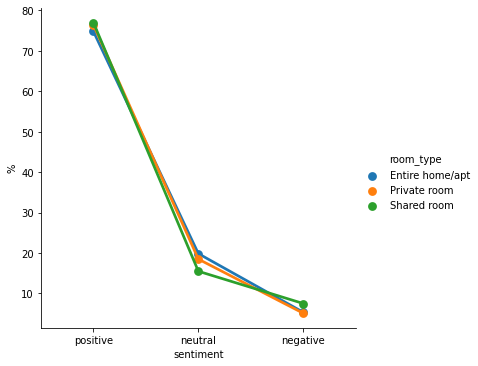

In [26]:
_ = np.round(b_rev2.groupby(['room_type'])['sentiment'].value_counts(1)*100,2).to_frame().rename(columns = {'sentiment':'%'}).reset_index()
sns.factorplot(data = _, x = 'sentiment', y = '%', hue = 'room_type')
plt.savefig('../images/boston_roomtype_sentiment.png')

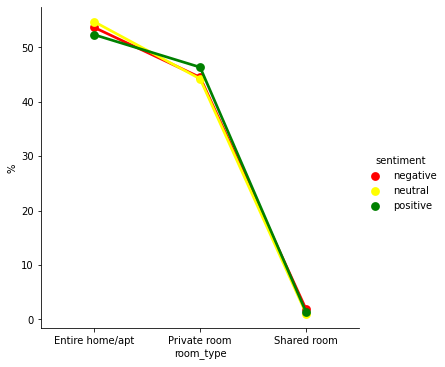

In [27]:
_ = np.round(b_rev2.groupby(['sentiment'])['room_type'].value_counts(1)*100,2).to_frame().rename(columns = {'room_type':'%'}).reset_index()
sns.factorplot(data = _, x = 'room_type', y = '%', hue = 'sentiment', palette = ['red','yellow','green'])
plt.savefig('../images/boston_sentiment_roomtype.png')

In [28]:
s_rev2 = s_rev.copy()

s_rev2.fillna('no review', inplace = True)
print(s_rev2.shape)
print(s_rev2.listing_id.nunique())
reviews = vectorizer.transform(s_rev2['comments'])
s_rev2['sentiment'] = nb_final.predict(reviews)
s_rev2 = s_rev2.merge(s_list[['id','room_type']].rename(columns = {'id':'listing_id'}), on = 'listing_id', how = 'left')
s_rev2.head(2)

(84849, 6)
3191


,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment,room_type
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,positive,Private room
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,positive,Private room


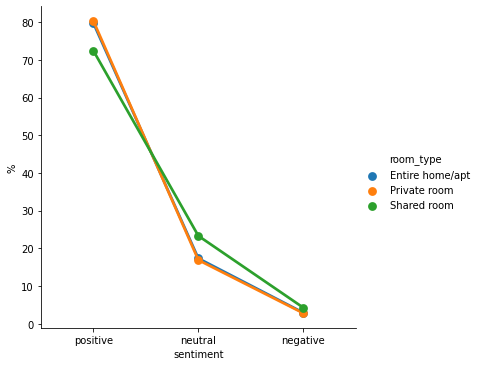

In [29]:
_ = np.round(s_rev2.groupby(['room_type'])['sentiment'].value_counts(1)*100,2).to_frame().rename(columns = {'sentiment':'%'}).reset_index()
sns.factorplot(data = _, x = 'sentiment', y = '%', hue = 'room_type')
plt.savefig('../images/seattle_roomtype_sentiment.png')

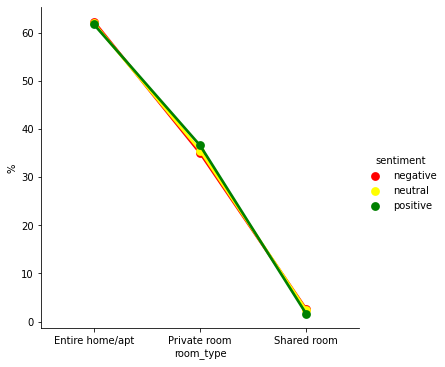

In [30]:
_ = np.round(s_rev2.groupby(['sentiment'])['room_type'].value_counts(1)*100,2).to_frame().rename(columns = {'room_type':'%'}).reset_index()
sns.factorplot(data = _, x = 'room_type', y = '%', hue = 'sentiment', palette = ['red','yellow','green'])
plt.savefig('../images/seattle_sentiment_roomtype.png')

#### Conclusion:
- In both cities, the positive sentiment is predominant for the 3 room types
- Only in Seattle there seem to be fewer positive reviews for shared rooms